<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model performance analysis


Model performance analysis using the following metrics:
*   mAP
*   mAR
*   fps
*   GFLOPs
*   Memory







### Initialization

In [29]:
# Parameters

dataset_name = 'COCO17'  # Dataset to evaluate: 'MASKD' or 'PWMFD' or 'COCO17'
gpus =  ['gtx960'] # Selected gpus to show results for (available: ['gtx960','k80'])

# Directories

results_dir = '/content/drive/MyDrive/object-detection-results/' + dataset_name

### Get requirements

In [ ]:
!pip install matplotlib==3.4

### Import packages

In [30]:
# Comment google.colab package if using local runtime
from google.colab import drive

import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)  # Maximum display width for table in pandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import textwrap as tw

# Function for converting mAP to percentage
def to_percent(mAP):
  if (type(mAP) == list or type(mAP) == np.ndarray):
    return [int(mAP_val*100) for mAP_val in mAP] 
  else:
    print(1)
    return int(mAP*100)

### Connect to GDrive for storage access

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Gather results from files

In [31]:
results_files = os.listdir(results_dir)
results_files = [file for file in results_files if ('.csv' in file) and (dataset_name in file) and (any([gpu in file for gpu in gpus]))]

print('Files found:')

# Gather results
results = pd.DataFrame(dtype=str, columns=['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score', 'gpu'])
for file in results_files:
  print(f'\t{file}')
  file_path = os.path.join(results_dir,file)
  results_temp = pd.read_csv(file_path)
  for gpu in gpus:
    if gpu in file:
      results_temp['gpu'] = gpu
  results = results.append(results_temp)
results = results.reset_index().iloc[:,1:-1]  # Drop uneeded columns
results = results.sort_values(by=['model','model_img_size'],ascending=[True,False])
# Put YOLOv5n last in order
results_yolov5n = results[results['model']=='YOLOv5n']
results = results[results['model']!='YOLOv5n']
results = results.append(results_yolov5n).reset_index().drop(columns=['index'])

Files found:
	COCO17_gtx960_yolov5s_640_metrics.csv
	COCO17_gtx960_yolov5m_640_metrics.csv
	COCO17_gtx960_yolov5l_640_metrics.csv
	COCO17_gtx960_yolov3_640_metrics.csv
	COCO17_gtx960_yolov3_spp_640_metrics.csv
	COCO17_gtx960_yolov3_tiny_640_metrics.csv
	COCO17_gtx960_ssdlite320_mobilenet_v3_large_metrics.csv
	COCO17_gtx960_ssd300_vgg16_metrics.csv
	COCO17_gtx960_maskrcnn_resnet50_fpn_metrics.csv
	COCO17_gtx960_yolov4_608_metrics.csv
	COCO17_gtx960_fasterrcnn_mobilenet_v3_large_320_fpn_metrics.csv
	COCO17_gtx960_fasterrcnn_mobilenet_v3_large_fpn_metrics.csv
	COCO17_gtx960_fasterrcnn_resnet50_fpn_metrics.csv
	COCO17_gtx960_retinanet_resnet50_fpn_metrics.csv
	COCO17_gtx960_yolov5n_640_metrics.csv


### Set plotting variables

In [32]:
# Plot variables
if dataset_name == 'COCO17':
  markers = ['>','o','v','^','s','p',
             'P','*','<','h','X','D','H','d','8']
  colors = ['tab:blue', 'tab:blue','tab:blue','tab:orange', 'tab:brown', 'tab:green','tab:green',
            'tab:red','tab:red','tab:red', 'tab:cyan', 'tab:purple', 'tab:purple','tab:purple','tab:purple']
  models = results.model.unique()
  models_short = ['FR-CNN MbNv3-L 320', 'FR-CNN MbNv3-L', 'FR-CNN RsN50', 'MR-CNN  RsN50', 'RtN RsN50', 'SSD300 VGG16', 'SSDlite320 MbNv3-L',
                  'YOLOv3','YOLOv3-spp','YOLOv3-tiny', 'YOLOv4', 'YOLOv5l', 'YOLOv5m', 'YOLOv5s', 'YOLOv5n']
else:
  markers = ['o','v','^','s','p',
             'P','*','h','X','D','d']
  colors = ['tab:blue', 'tab:blue','tab:blue','tab:orange', 'tab:brown', 'tab:green','tab:green',
            'tab:red','tab:red','tab:red', 'tab:cyan', 'tab:purple','tab:purple','tab:purple']
  models = results.model.unique()
  models_short = models

### Gather metrics


In [33]:
# Get following model metrics

# mAP per IoU
mAP = results[  # COCO Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_50 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_75 = results[  # PASCAL VOC Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.75') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values

# mAP per object size
mAP_small = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'small') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_medium = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'medium') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_large = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'large') &
              (results['max_dets'] == 100)
              ]['score'].values
          
# mAR per maximum detections
mAR = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_1 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 1)
              ]['score'].values
mAR_10 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 10)
              ]['score'].values

#mAR per object size
mAR_small = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'small') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_medium = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'medium') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_large = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'large') &
              (results['max_dets'] == 100)
              ]['score'].values


### Show performance table

In [34]:
grouped_results = results.groupby(by=['model','model_img_size'])

perf_table = grouped_results.first().iloc[:,:4].reset_index()
# Put YOLOv5n last in order
perf_table_yolov5n = perf_table[perf_table['model']=='YOLOv5n']
perf_table = perf_table[perf_table['model']!='YOLOv5n']
perf_table = perf_table.append(perf_table_yolov5n).reset_index().drop(columns=['index'])

model_params = perf_table['model_params'].values
model_gflops = perf_table['model_gflops'].values
fps = perf_table['fps'].values
max_mem = perf_table['max_mem'].values

perf_table['map'] = mAP
perf_table['map_50'] = mAP_50
perf_table['map_75'] = mAP_75
perf_table['mar'] = mAR
  
perf_table = perf_table.round(2)  # Round to two decimals

perf_table

,model,model_img_size,model_params,model_gflops,fps,max_mem,map,map_50,map_75,mar
0,Faster R-CNN MobileNetV3-Large 320 FPN,320,19.4,1.4,41.96,195.67,0.23,0.38,0.23,0.29
1,Faster R-CNN MobileNetV3-Large FPN,800,19.4,9.0,12.24,304.76,0.33,0.53,0.34,0.44
2,Faster R-CNN ResNet-50 FPN,800,41.8,240.4,3.55,593.81,0.37,0.59,0.40,0.51
3,Mask R-CNN ResNet-50 FPN,800,44.4,259.9,3.29,603.65,0.38,0.59,0.41,0.52
4,RetinaNet ResNet-50 FPN,800,34.0,303.5,3.20,428.73,0.36,0.56,0.38,0.54
5,SSD300 VGG16,300,35.6,69.8,14.84,209.81,0.25,0.42,0.26,0.36
6,SSDlite320 MobileNetV3-Large,320,3.4,1.2,26.10,33.27,0.21,0.34,0.22,0.33
7,YOLOv3,640,61.9,156.3,11.09,300.77,0.37,0.52,0.40,0.44
8,YOLOv3-spp,640,63.0,157.1,11.92,306.23,0.38,0.54,0.41,0.44
9,YOLOv3-tiny,640,8.8,13.3,69.37,91.42,0.12,0.22,0.12,0.15


### Plot fps per GPU (Only for more than one gpu selected)

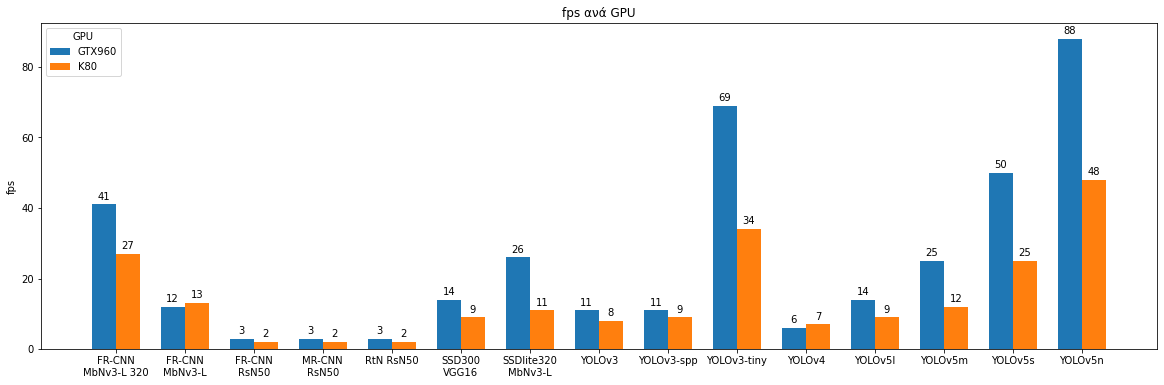

In [28]:
groups_per_gpu = results.groupby(by=['model','model_img_size','gpu'])

fps_per_gpu = groups_per_gpu.first().iloc[:,[2]].reset_index()
# Put YOLOv5n last in order
fps_per_gpu_yolov5n = fps_per_gpu[fps_per_gpu['model']=='YOLOv5n']
fps_per_gpu = fps_per_gpu[fps_per_gpu['model']!='YOLOv5n']
fps_per_gpu = fps_per_gpu.append(fps_per_gpu_yolov5n).reset_index().drop(columns=['index'])

fps_gtx960 = fps_per_gpu[fps_per_gpu['gpu']=='gtx960']['fps'].values
fps_k80 = fps_per_gpu[fps_per_gpu['gpu']=='k80']['fps'].values

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

gtx960_bar = ax.bar(x - width/2, [int(val) for val in fps_gtx960], width, label='GTX960')
k80_bar = ax.bar(x + width/2, [int(val) for val in fps_k80], width, label='K80')

ax.set_ylabel('fps')
ax.set_title('fps ανά GPU')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
ax.legend(title='GPU')

ax.bar_label(gtx960_bar, padding=3)
ax.bar_label(k80_bar, padding=3)

plt.show()

### Plot  mAP / fps or mAR / fps (change parameters)

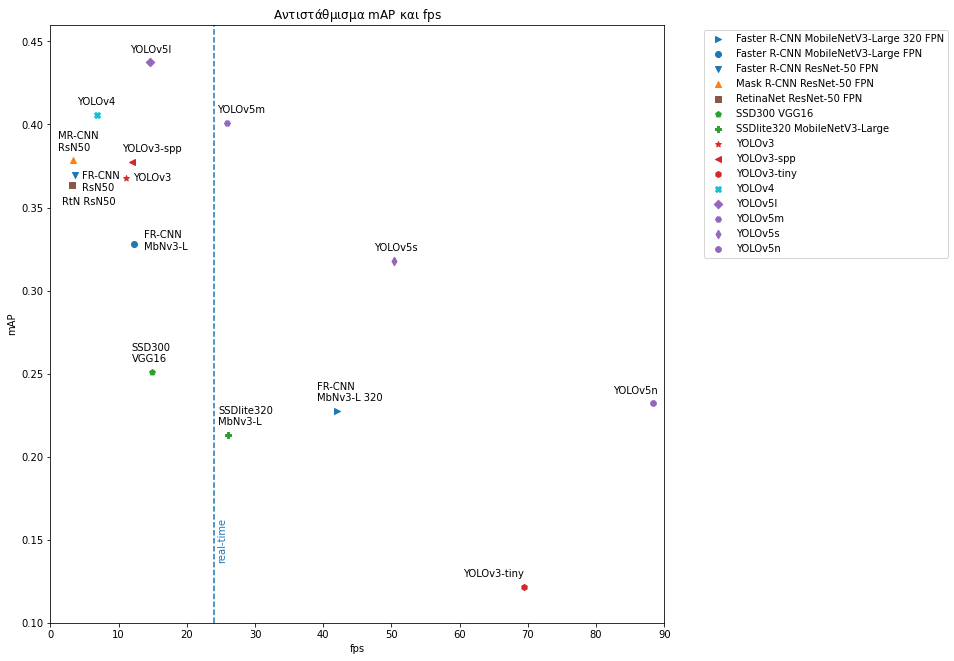

In [8]:
# Parameters
metric_name = 'avg_precision' # avg_precision or avg_recall
iou = '0.50:0.95'
area = 'all'
max_dets = 100

# Flags
show_iou = True if not iou == '0.50:0.95' else False  # show iou in plot title or not
show_area = True if not area == 'all' else False  # show area in plot title or not
show_max_dets = False  # show max_dets in plot title or not

# Get metric values
metric = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == metric_name) & 
              (results['iou'] == iou) &
              (results['area'] == area) &
              (results['max_dets'] == max_dets)
              ]['score'].values

# Start plotting
plt.figure(figsize=(11,11))

metric_superscript = f'{area},max={max_dets}' if show_area & show_max_dets else area if show_area else f'max={max_dets}' if show_max_dets else ''  # metric superscript for the plot's title
metric_name_short = 'mAP' if metric_name == 'avg_precision' else 'mAR' if metric_name == 'avg_recall' else ''  # metric name for the plot's title
iou_script = f'@[{iou.replace("0.",".")}]' if show_iou else ''  # iou script for plot's title
plt.title('Αντιστάθμισμα ' + metric_name_short + '$^{' + metric_superscript + '}$' + iou_script + ' και fps' )

plt.ylabel(metric_name_short)
plt.xlabel('fps')

if dataset_name == 'COCO17':
  if metric_name == 'avg_precision':
    xlim = (0,90)
    ylim = (0.1,0.46)
  elif metric_name == 'avg_recall':
    xlim = (0,90)
    ylim = (0.1,0.6)
if dataset_name == 'PWMFD':
  xlim = (0,90)
  ylim = (0.1,0.9)

plt.xlim(xlim)
plt.ylim(ylim)

for i in range(0,len(models)):

  # Point annotation distance tuning
  if dataset_name == 'COCO17':

    if metric_name == 'avg_precision':

      xytext = (-20,10)
      if models[i] == 'SSDlite320 MobileNetV3-Large':
        xytext = (-10,10)
      if models[i] == 'Faster R-CNN ResNet-50 FPN':
        xytext = (7,-15)
      if models[i] == 'Mask R-CNN ResNet-50 FPN':
        xytext = (-15,10)
      if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
        xytext = (10,-5)
      if models[i] == 'YOLOv3':
        xytext = (7,-3)
      if models[i] == 'YOLOv3-spp':
        xytext = (-10,10)
      if models[i] == 'YOLOv5m':
        xytext = (-10,10)
      if models[i] == 'YOLOv5n':
        xytext = (-40,10)
      if models[i] == 'YOLOv3-tiny':
        xytext = (-60,10)
      if models[i] == 'RetinaNet ResNet-50 FPN':
        xytext = (-10,-20)

    if metric_name == 'avg_recall':
      xytext = (-20,10)
      if models[i] == 'SSDlite320 MobileNetV3-Large':
        xytext = (-10,10) 
      if models[i] == 'Faster R-CNN ResNet-50 FPN':
        xytext = (10,-15)
      if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
        xytext = (10,-15)
      if models[i] == 'YOLOv3':
        xytext = (-5,-20) 
      if models[i] == 'YOLOv4':
        xytext = (-30,10)
      if models[i] == 'YOLOv5m':
        xytext = (-10,10)
      if models[i] == 'YOLOv5n':
        xytext = (-35,10)
      if models[i] == 'YOLOv3-tiny':
        xytext = (-60,10)
      if models[i] == 'RetinaNet ResNet-50 FPN':
        xytext = (-20,10)
      if models[i] == 'Mask R-CNN ResNet-50 FPN':
        xytext = (10,5)
  elif dataset_name == 'PWMFD':
    xytext = (-20,10)

  # Point annotations
  if dataset_name == 'COCO17':
    plt.annotate(tw.fill(models_short[i], width=11), (fps[i], metric[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(fps[i],metric[i],marker=markers[i],color=colors[i])

# Plot vertical line for real-time fps
if dataset_name == 'COCO17':
  plt.vlines(x=24, ymin=ylim[0], ymax=ylim[1], colors='tab:blue', linestyles='dashed')
  plt.text(24.5, 0.15, "real-time", rotation=90, verticalalignment='center', color='tab:blue')


plt.legend(models, scatterpoints=1, bbox_to_anchor=(1.47, 1.00))

plt.show()

### Plot  mAP or mAR (small,medium,large) per model (change parameters)

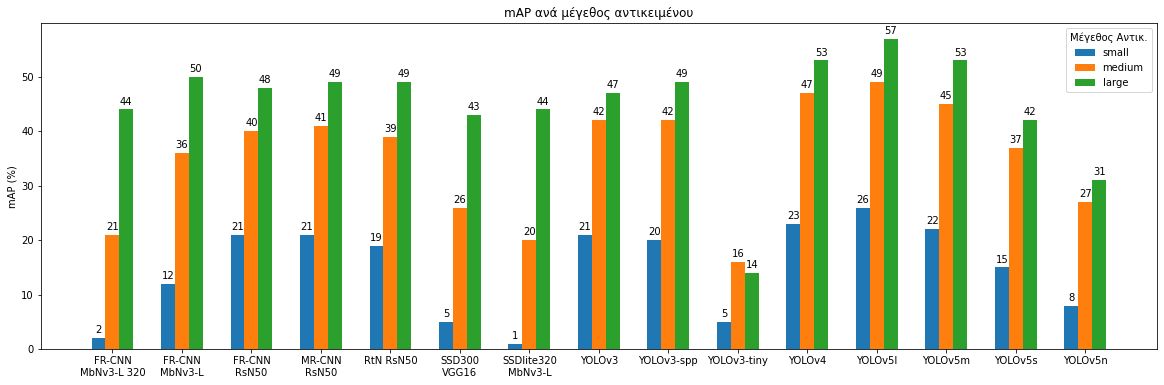

In [10]:
# Parameters
metric_name = 'avg_precision'  # avg_precision or avg_recall

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

if metric_name == 'avg_precision':
  metric_name_short = 'mAP'
  metric_small = mAP_small 
  metric_medium = mAP_medium
  metric_large = mAP_large
elif metric_name == 'avg_recall':
  metric_name_short = 'mAR'
  metric_small = mAR_small 
  metric_medium = mAR_medium
  metric_large = mAR_large

small_bar = ax.bar(x - width, to_percent(metric_small), width, label='small')
medium_bar = ax.bar(x, to_percent(metric_medium), width, label='medium')
large_bar = ax.bar(x + width, to_percent(metric_large), width, label='large')

ax.set_ylabel(f'{metric_name_short} (%)')
ax.set_title(f'{metric_name_short} ανά μέγεθος αντικειμένου')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
ax.legend(title='Μέγεθος Αντικ.')

ax.bar_label(small_bar, padding=3)
ax.bar_label(medium_bar, padding=3)
ax.bar_label(large_bar, padding=3)


plt.show()

### Plot  mAP (IoU = [0.50,0.75.0,50:0,0.95]) per model

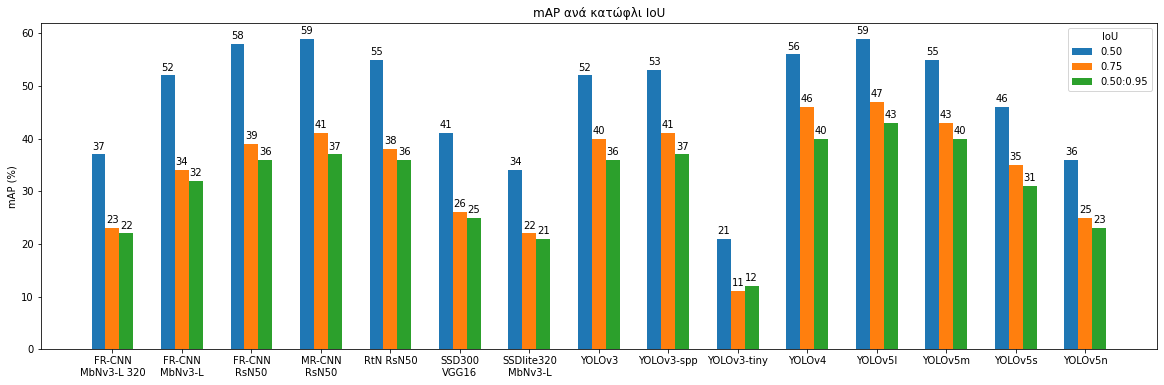

In [11]:
# Parameters

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars


# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

iou50_bar = ax.bar(x - width, to_percent(mAP_50), width, label='0.50')
iou75_bar = ax.bar(x, to_percent(mAP_75), width, label='0.75')
iou5095_bar = ax.bar(x + width, to_percent(mAP), width, label='0.50:0.95')

ax.set_ylabel('mAP (%)')
ax.set_title('mAP ανά κατώφλι IoU')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
ax.legend(title='IoU')

ax.bar_label(iou50_bar, padding=3)
ax.bar_label(iou75_bar, padding=3)
ax.bar_label(iou5095_bar, padding=3)


plt.show()

### Plot  mAR (max det = [1,10,100]) per model

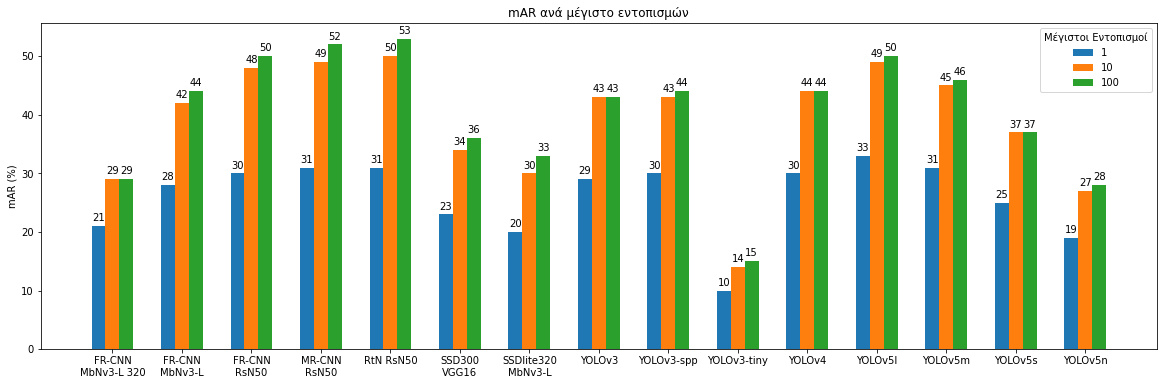

In [12]:
# Parameters

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars


# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

max1_bar = ax.bar(x - width, to_percent(mAR_1), width, label='1')
max10_bar = ax.bar(x, to_percent(mAR_10), width, label='10')
max100_bar = ax.bar(x + width, to_percent(mAR), width, label='100')

ax.set_ylabel('mAR (%)')
ax.set_title('mAR ανά μέγιστο εντοπισμών')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
ax.legend(title='Μέγιστοι Εντοπισμοί')

ax.bar_label(max1_bar, padding=3)
ax.bar_label(max10_bar, padding=3)
ax.bar_label(max100_bar, padding=3)


plt.show()

### Plot model mAP / GFLOPs

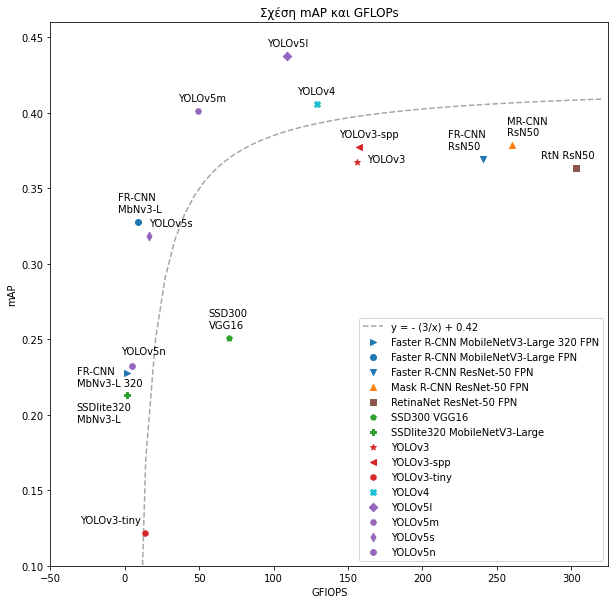

In [18]:
%matplotlib inline

# Start plotting
plt.figure(figsize=(10,10))

plt.title('Σχέση mAP και GFLOPs')
plt.xlabel('GFlOPS')
plt.ylabel('mAP')

xlim = (-50,325)
ylim = (0.1,0.46)
plt.xlim(xlim)
plt.ylim(ylim)

# Plot hyperbole
x = np.linspace(1,320)
y = - 3.5 * 1/x + 0.42
plt.plot(x,y,'--',color='#a6a6a6',zorder=0)

# Plot points
for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-35,10) 
  if models[i] == 'Faster R-CNN MobileNetV3-Large 320 FPN':
    xytext = (-50,-13)
  if models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (-5,10)
  if models[i] == 'YOLOv3':
    xytext = (10,0) 
  if models[i] == 'YOLOv3-tiny':
    xytext = (-65,10) 
  if models[i] == 'YOLOv5s':
    xytext = (0,10) 
  if models[i] == 'YOLOv5n':
    xytext = (-10,12) 
  if models[i] == 'SSDlite320 MobileNetV3-Large':
    xytext = (-50,-27)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-35,10)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (model_gflops[i], mAP[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_gflops[i],mAP[i], marker=markers[i], color=colors[i])

plt.legend(np.insert(models,0,'y = - (3/x) + 0.42'), scatterpoints=1)

plt.show()

### Plot model fps / GFLOPs

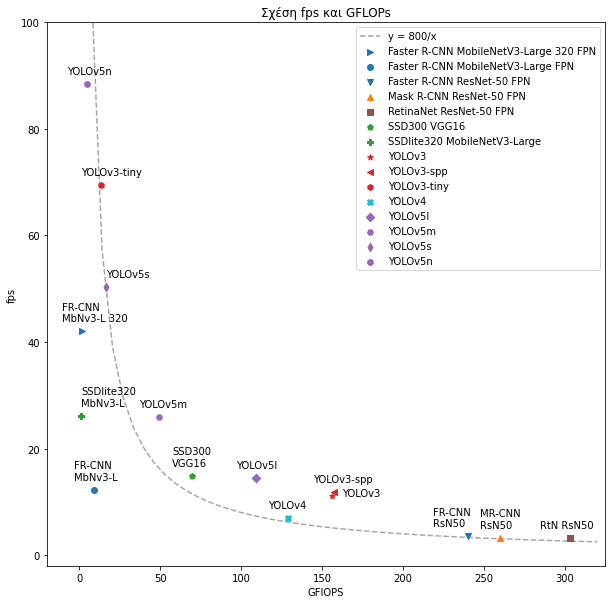

In [21]:
%matplotlib inline

# Start plotting
plt.figure(figsize=(10,10))

plt.title('Σχέση fps και GFLOPs')
plt.xlabel('GFlOPS')
plt.ylabel('fps')

xlim = (-20,325)
ylim = (-2,100)
plt.xlim(xlim)
plt.ylim(ylim)

# Plot hyperbole
x = np.linspace(1,320)
y = 800 * 1/x
plt.plot(x,y,'--',color='#a6a6a6',zorder=0)

# Plot points
for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-35,10) 
  if models[i] == 'YOLOv3':
    xytext = (10,0) 
  if models[i] == 'YOLOv5s':
    xytext = (0,10) 
  if models[i] == 'SSDlite320 MobileNetV3-Large':
    xytext = (0,10)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-30,10)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (model_gflops[i], fps[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_gflops[i],fps[i], marker=markers[i], color=colors[i])

plt.legend(np.insert(models,0,'y = 800/x'), scatterpoints=1)

plt.show()

### Sort models based on normalized (fps + mAP) score

In [35]:
norm_fps = (fps-fps.min())/(fps.max()-fps.min())
norm_mAP = (mAP-mAP.min())/(mAP.max()-mAP.min())

norm_score = norm_fps + norm_mAP

sorted_models = pd.DataFrame()
sorted_models['model'] = models
sorted_models['score'] = norm_score

sorted_models.sort_values(by=['score'], ascending=False)

,model,score
14,YOLOv5n,1.349900
13,YOLOv5s,1.175836
12,YOLOv5m,1.151679
11,YOLOv5l,1.133182
10,YOLOv4,0.943182
8,YOLOv3-spp,0.912428
7,YOLOv3,0.871728
3,Mask R-CNN ResNet-50 FPN,0.814259
0,Faster R-CNN MobileNetV3-Large 320 FPN,0.790770
2,Faster R-CNN ResNet-50 FPN,0.788866
